# Gaussian Processes for Dummies

These are notes I took from this awesome blog post by Katherine Bailey: https://katbailey.github.io/post/gaussian-processes-for-dummies/

Here are the things I needed to hear for everything to click:

* a Gaussian Process (GP) constrains functions by describing how correlated the values $y_i$ and $y_j$ must be, as a function of the distance between $x_i$ and $x_j$. It is essentially a prior, which we can combine with data to obtain a posterior.

* when people introduce GPs they very often use a Gaussian function (also called squared exponential, or radial basis function) to describe the correlation between $x_i$ and $x_j$, but this is not where the *Gaussian* in Gaussian Process comes from. You can use many types of kernels, for instance a periodic kernel, if you have reasons to believe their is periodicity in your data. In some cases you can even keep the period as a free parameter and optimise your fitting procedure to estimate it.

For a given kernel, you can obtain one possible function by first defining a bunch of $x$-values (here we pick 50, from -5 to +5), then using the kernel and the distance between each pair to build the correlation matrix which we call here $K_{**}$ (written `K_ss` in the code). At the end we sample a random point in a 50-dimensional normal distribution of covariance $K_{**}$. This gives us 50 $y$-values: and that's it! We have *sampled a function from the prior defined by our chosen kernel*.

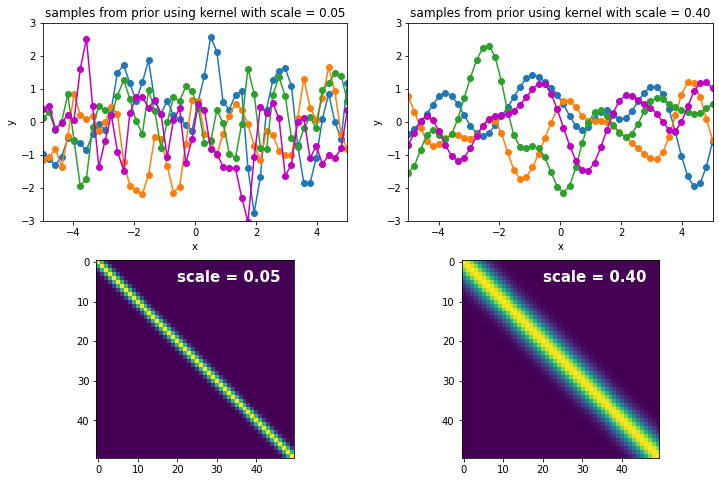

In [114]:
import numpy as np
import matplotlib.pyplot as plt

# Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function: here a normal (aka RBF for radial basis function, or Gaussian)
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist) 

param = [0.05,0.4]


plt.figure(figsize=(12,8))
for iii in range(2):
    
    plt.subplot(2,2,iii+1)

    K_ss = kernel(Xtest, Xtest, param[iii])
    
    # - - -    Option 1: generate uncorrelated Gaussian, tilt it:
    # (from K. Bailey's Gaussian Processes for dummies)
    #
    # Get cholesky decomposition (square root) of the
    # covariance matrix
    L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))
    # Sample 3 sets of standard normals for our test points,
    # multiply them by the square root of the covariance matrix
    f_prior = np.dot(L, np.random.normal(size=(n,3)))

    # - - -    Option 2: pick an already correlated Gaussian sample:
    f_prior_direct = np.random.multivariate_normal( np.zeros(n) , K_ss)

    # Now let's plot the 3 sampled functions.
    plt.plot(Xtest, f_prior,'o-')
    plt.plot(Xtest, f_prior_direct,'o-',c='m')

    plt.axis([-5, 5, -3, 3])
    plt.title('samples from prior using kernel with scale = %.2f' % (param[iii]))
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.subplot(2,2,iii+3)
    plt.imshow(K_ss)
    plt.text(20 , 5 ,'scale = %.2f' % (param[iii]) , c='w' , fontsize=15 , fontweight='bold')

All functions in the top left panel have the same correlation structure: the short correlation length means that points are basically only correlated to their nearest neighbour, so you sometimes get two points in a row with similar Y values, but rarely three or more. It looks a bit like random noise, with Y values jumping quickly.

In the top right panel the correlation scale is longer, so the variations are smoother, and you can often spot groups of five or more points in a row with similar values of Y.

## Regression with the RBF kernel

If I have data points with a measured $x$ and $y = f(x)$, I can generate a bunch of functions that go through my points while following the chosen kernel. I can sample from the combination of the prior (the kernel) and the data, to obtain a posterior.

Given a chosen kernel, and a set of $f$ observed values, we can calculate a posterior distribution for the values $f_{*}$ that we haven't observed.

$$\begin{pmatrix}
f \\
f_{*}
\end{pmatrix}
\sim \mathcal{N}{\left(
\begin{pmatrix}
\mu \\
\mu_{*}
\end{pmatrix}
,
\begin{pmatrix}
K & K_{*}\\
K_{*}^T & K_{**}\\
\end{pmatrix}
\right)}$$

In this case we have 5 points in the training set, and we want to predict the value of the function at 50 new locations.

$K$ (`K` in the code) is a 5x5 matrix, obtained by applying the kernel function to the pairwise distances between the observed $x$ values.

$K_{*}$ (`K_s` in the code) is a 5x50 matrix, obtained from the pairwise distance of every observed $x$ to every new location.

$K_{**}$ (`K_ss` in the code) is the 50x50 matrix we have used above.

Math not shown here but performed in the code: there is a way to obtain directly the mean predicted `mu` at each of the 50 new locations. This function goes through all the observed points. We can also obtain `stdv` at any location, which is the standard deviation of the prediction.

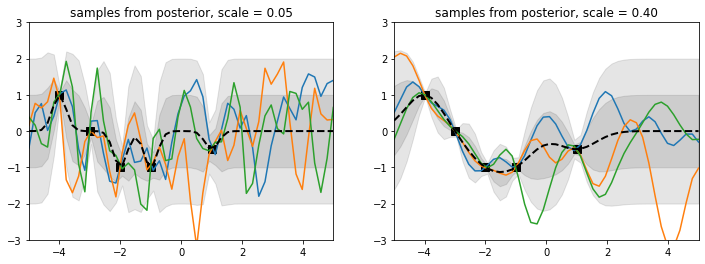

In [115]:
# Noiseless training data (i.e. the observations)
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.array([1, 0, -1, -1, -0.5]).reshape(5,1)

plt.figure(figsize=(12,4))

for iii in range(2):

    # Apply the kernel function to our training points
    K = kernel(Xtrain, Xtrain, param[iii])
    L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

    # Compute the mean at our test points.
    K_s = kernel(Xtrain, Xtest, param[iii])
    Lk = np.linalg.solve(L, K_s)
    mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))
    
    # Compute K_ss
    K_ss = kernel(Xtest, Xtest, param[iii])

    # Compute the standard deviation so we can plot it
    s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
    stdv = np.sqrt(s2)
    # Draw samples from the posterior at our test points.
    L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

    plt.subplot(1,2,iii+1)
    plt.plot(Xtrain, ytrain, 'ks', ms=8)
    plt.plot(Xtest, f_post)
    plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="k",alpha=0.1)
    plt.gca().fill_between(Xtest.flat, mu-1*stdv, mu+1*stdv, color="k",alpha=0.1)

    plt.plot(Xtest, mu, 'k--', lw=2)
    plt.axis([-5, 5, -3, 3])
    plt.title('samples from posterior, scale = %.2f' % (param[iii]))


The posterior does not actually have zero dispersion at the data points.

Let's see what happens with noisy data.

# RBF with noise

Text(0.5, 1.0, 'noiseless RBF kernel, scale = 2.00')

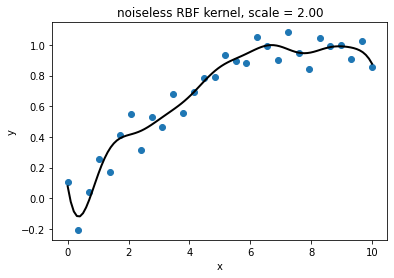

In [169]:
Ntrain = 30
Xtrain = np.linspace(0,10,Ntrain).reshape(Ntrain,1)
ytrain = np.sin(Xtrain / 5.) + np.random.normal(loc=0,scale=0.1,size=Ntrain).reshape(Ntrain,1)

plt.figure()
plt.scatter( Xtrain , ytrain )
plt.xlabel('x'); plt.ylabel('y')

# Grid to evaluate the posterior function
n = 100
Xtest = np.linspace(0, 10, n).reshape(-1,1)

param = 2.

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute K_ss
K_ss = kernel(Xtest, Xtest, param)

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))


plt.plot(Xtest, mu , c='k' , lw=2)
plt.title('noiseless RBF kernel, scale = %.2f' % (param))

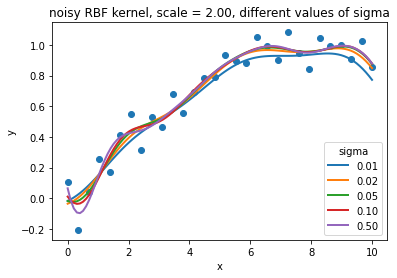

In [180]:
def kernel_with_sigma(a, b, param, sigma):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return sigma**2 * np.exp(-.5 * (1/param) * sqdist) 

plt.figure()
plt.scatter( Xtrain , ytrain )
plt.xlabel('x'); plt.ylabel('y')

for sigma in [0.01,0.02,0.05,0.1,0.5]:

    # Apply the kernel function to our training points
    K = kernel_with_sigma(Xtrain, Xtrain, param, sigma)
    L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

    # Compute the mean at our test points.
    K_s = kernel_with_sigma(Xtrain, Xtest, param, sigma)
    Lk = np.linalg.solve(L, K_s)
    mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

    # Compute K_ss
    K_ss = kernel_with_sigma(Xtest, Xtest, param, sigma)

    # Compute the standard deviation so we can plot it
    s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
    stdv = np.sqrt(s2)
    # Draw samples from the posterior at our test points.
    L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

    plt.plot(Xtest, mu , lw=2,label='%.2f' % (sigma))

    
plt.title('noisy RBF kernel, scale = %.2f, different values of sigma' % (param))
plt.legend(title='sigma',loc='lower right')
plt.show()

## Linear kernel

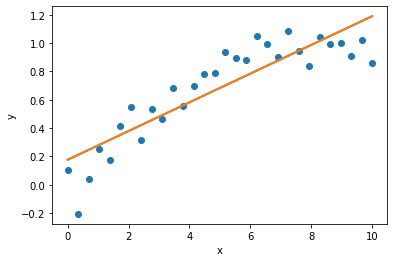

In [273]:
def linear_kernel(a,b,sigmaa_squared,sigmab_squared,c):
    """
    Returns the covariance matrix between a list of a and list of b values.
    c is our prior knowledge of where the function has y=0
    sigmab_squared represents our certainty on the value of c
    sigmaa_squared the overall noise in the data
    """
    aaa = a * np.ones((len(a),len(b))) - c
    bbb = (b * np.ones((len(b),len(a)))).T - c
    k = sigmaa_squared*aaa*bbb + sigmab_squared
    return k

plt.figure()
plt.scatter( Xtrain , ytrain )
plt.xlabel('x'); plt.ylabel('y')

# Apply the kernel function to our training points
K = linear_kernel(Xtrain, Xtrain, 0.001, 0.01, 0)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = linear_kernel(Xtrain, Xtest, 0.001, 0.01, 0)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute K_ss
K_ss = linear_kernel(Xtest, Xtest, 0.001, 0.01, 0)

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

plt.plot(Xtest, mu , lw=2,label='%.2f' % (sigma))


# redo

# Apply the kernel function to our training points
K = linear_kernel(Xtrain, Xtrain, 0.001, 0.1, 5)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = linear_kernel(Xtrain, Xtest, 0.001, 0.1, 5)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute K_ss
K_ss = linear_kernel(Xtest, Xtest, 0.001, 0.1, 5)

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

plt.plot(Xtest, mu , lw=2,label='%.2f' % (sigma))


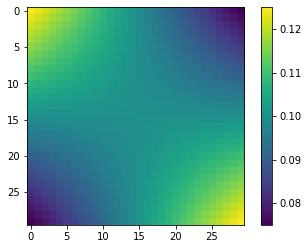

In [274]:
plt.imshow(K)
plt.colorbar()